### Практическое задание

1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote. 

2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

4. (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [390]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np

In [391]:
# сгенерируем данные, представляющие собой 500 объектов с пятью признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 1, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

Реализуем генерацию $N$ бутстрэп-выборок и подмножества признаков для нахождения разбиения в узле.

In [392]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [393]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями.

In [394]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [395]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [396]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [397]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [398]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [399]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее пяти объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [400]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [401]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [402]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [403]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [404]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим практическим заданием к этому уроку.

In [405]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [406]:
# Введём функцию подсчёта точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

In [415]:

def get_meshgrid(data, step=.05, border=.5):
    '''
    Функция для получения сетки точек (x1, x2) 
    для дальнейшего отображения их на графиках
    
    Параметры:
    1) data - входной датасет, набор точек (x1_i, x2_i);
    2) step - мелкость сетки;
    3) border - отступ от минимальных и максимальных значений x1, x2 в data 
    в сетке
    '''
    
    x1_min, x1_max = data[:, 0].min() - border, data[:, 0].max() + border
    x2_min, x2_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x1_min, x1_max, step), 
                       np.arange(x2_min, x2_max, step))
def plot_decision_surface(
    n_trees, X_train, y_train, X_test, y_test, colors=colors, 
    light_colors=light_colors, title=''
):
    '''
    Функция для отображения разделяющей поверхности классификатора
    
    Параметры:
    1) Количество деревьев в ансамбле
    2) X_train, y_train - данные и разметка обучающей выборки;
    3) X_test, y_test - данные и разметка тестовой выборки;
    4) colors - цвета для отображения точек из разных классов;
    5) light_colors - цветовая схема для отображения разделяющей поверхности;
    6) title - заголовок графика.
    
    '''
    
    forest = random_forest(X_train, y_train, n_trees)  # обучаем модель
    
    plt.figure(figsize=(16, 6))
    
    # отображаем разделяющую поверхность и точки обучающей выборки
    plt.subplot(1,2,1)
    x1_values, x2_values = get_meshgrid(X_train)
    x1_ravel, x2_ravel = x1_values.ravel(), x2_values.ravel()
    mesh_predictions_ravel = tree_vote(forest, (np.c_[x1_ravel, x2_ravel]))
    mesh_predictions = np.array(mesh_predictions_ravel).reshape(x1_values.shape)
    
    plt.grid(False)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                s=100, cmap=colors, edgecolors='black')
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.title('Обучающая выборка, accuracy_metric = {:.4f}%'.format(
        accuracy_metric(y_train, tree_vote(forest, X_train))
    ))
    
    # отображаем разделяющую поверхность и точки тестовой выборки
    plt.subplot(1,2,2)
    plt.grid(False)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                s=100, cmap=colors, edgecolors='black')
    plt.title('Тестовая выборка, accuracy_metric = {:.4f}%'.format(
        accuracy_metric(y_test, tree_vote(forest, X_test))
    ))
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.suptitle(title, fontsize=20)

### Задание 1

Построим лес из одного дерева.

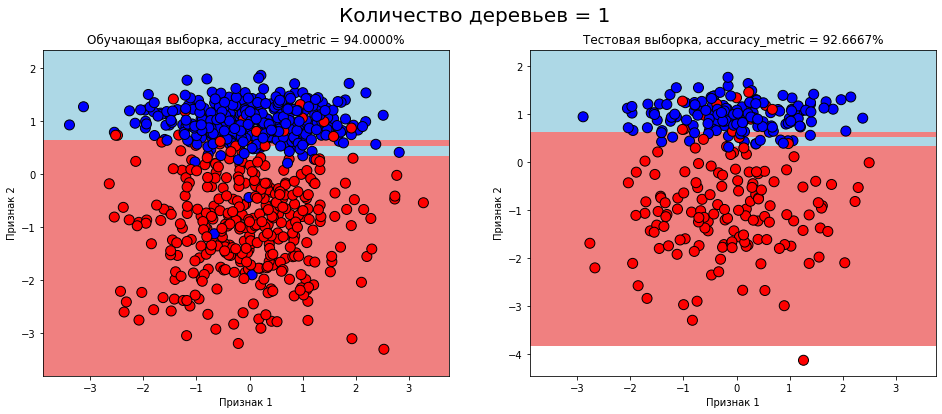

In [416]:
plot_decision_surface(1, train_data, train_labels, test_data, test_labels, title='Количество деревьев = 1')

Построим лес из трёх деревьев.

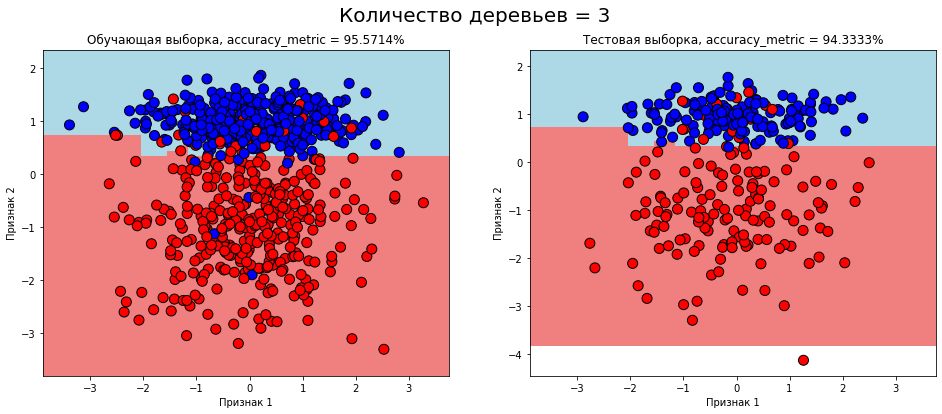

In [417]:
plot_decision_surface(3, train_data, train_labels, test_data, test_labels, title='Количество деревьев = 3')

Построим лес из десяти деревьев.

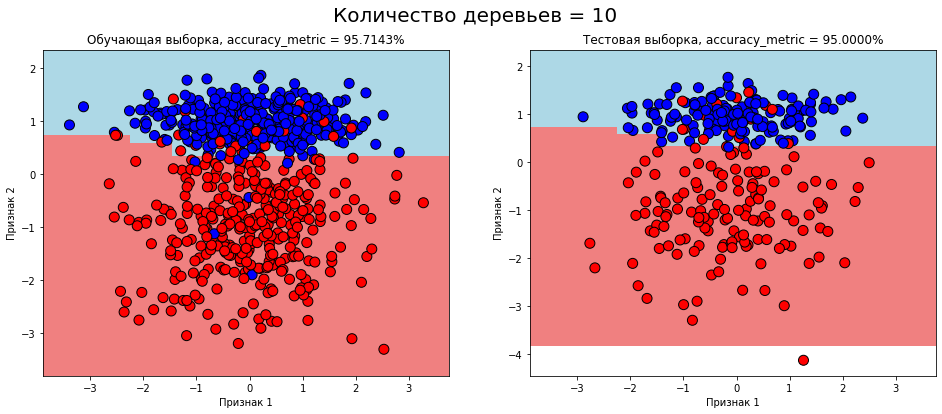

In [418]:
plot_decision_surface(10, train_data, train_labels, test_data, test_labels, title='Количество деревьев = 10')

Построим лес из пятидесяти деревьев.

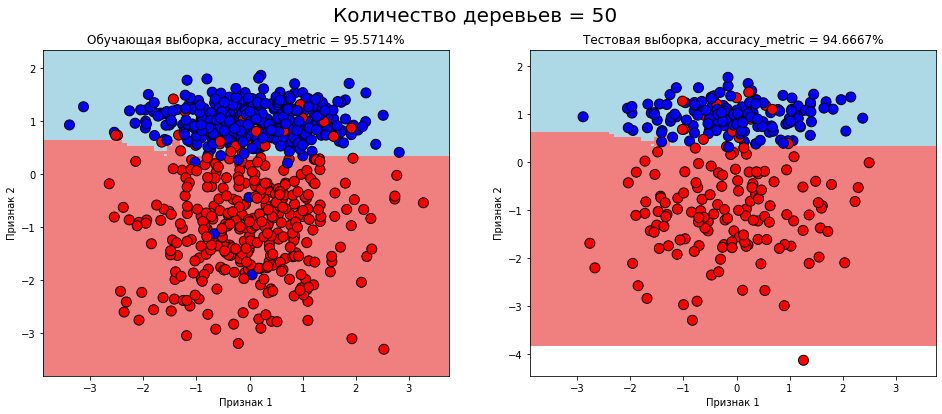

In [419]:
plot_decision_surface(50, train_data, train_labels, test_data, test_labels, title='Количество деревьев = 50')

### Задание 2

- Мы видим, что чем больше деревьев в ансамбле, тем сложнее разделяющая поверхность и тем меньшее переобучение мы наблюдаем.

### Задание 4

- Функцию модифицировал. Деревья первых заданий строятся уже по критерию энтропии Шенона.

In [420]:
# Расчёт энтропии Шенона

def entrop(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity